In [12]:
import torch
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
import numpy as np
import pandas as pd
import awkward as ak
from numba import njit
import vector
import numba as nb
import numpy.ma as ma
from torch.utils.data import DataLoader

vector.register_numba()
vector.register_awkward()


hep.style.use(hep.style.ROOT)

from particle import Particle
import torch
from memflow.phasespace.phasespace import PhaseSpace
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from  memflow.phasespace.utils import *
torch.set_default_dtype(torch.double)

2023-03-24 10:30:53.503095: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-24 10:30:54.274715: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/LHAPDF/lib:/opt/MG5_aMC_v3_4_1/lib:/.singularity.d/libs
2023-03-24 10:30:54.274823: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/LHAPDF/lib:/opt/MG5_aMC_v3_4_1/lib:/.singularity.d/libs
2023-0

In [4]:
tot_final_state_masses = sum([Particle.from_pdgid(pdg).mass / 1e3 for pdg in [6,-6,25]])
E_cm = 13000
absolute_Ecm_min = 1
tau_min = (tot_final_state_masses / 13000.)**2

# Log sampling method

The strategy:   move $$x_1 x_2 > (\sum M / E_{cm})^2$$ to
$$\log x_1 + \log x_2 > log( (\sum M / E_{cm})^2) $$ and then to create a positive defined pdf
$$-\log x_2 < -log( (\sum M / E_{cm})^2) + \log x_1  $$ 
Sample uniformly from the CDF of the linear relation to get the log(x1) distributed correctly. Then sample uniformly on the y axis. 
Conver back to exponential form and enjoy

In [66]:
rnd = torch.rand(1_000_000, 2)

Assuming $y = mx + q$, for the cumulative we get $u = \frac{m}{2A} x^2 + \frac{q}{A}x$ with $u$ distributed uniformly.

In [67]:
def cdf(x, m, q):
    A = (m/2)*q**2 + q**2  # normalization of the curve
    ycum = ((m/2)*x**2 + q*x)/A
    return ycum

In [81]:
def inverse_cdf(u, m, q): 
    A = (m/2)*q**2 + q**2
    return ( -q/A + torch.sqrt((-q/A)**2 + 2 *m*u/A))/(m/A)

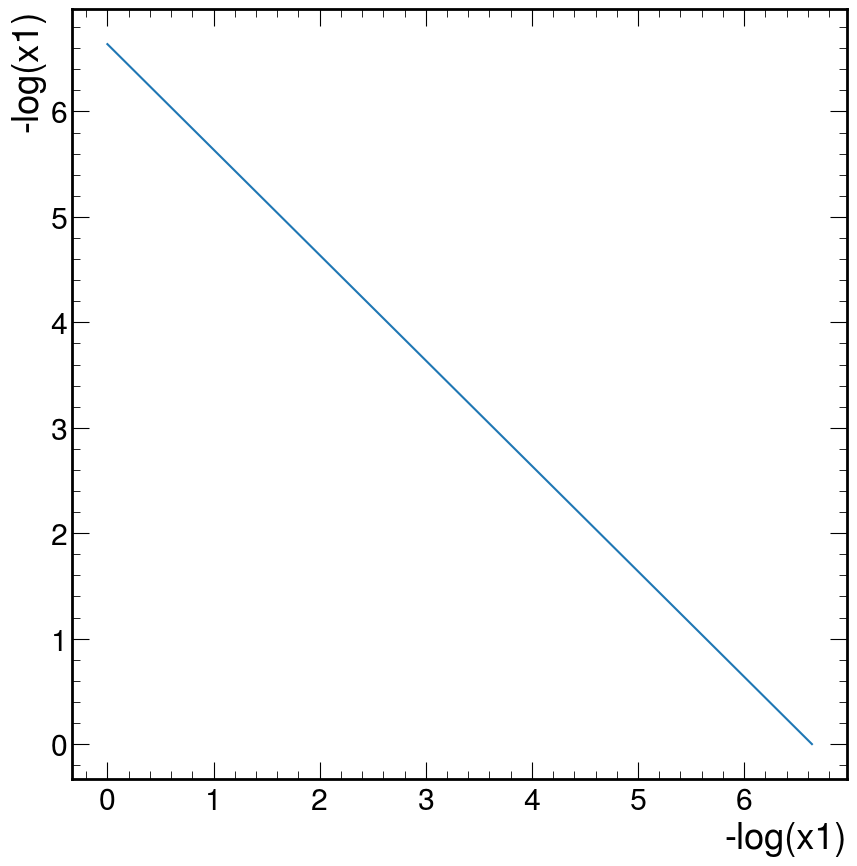

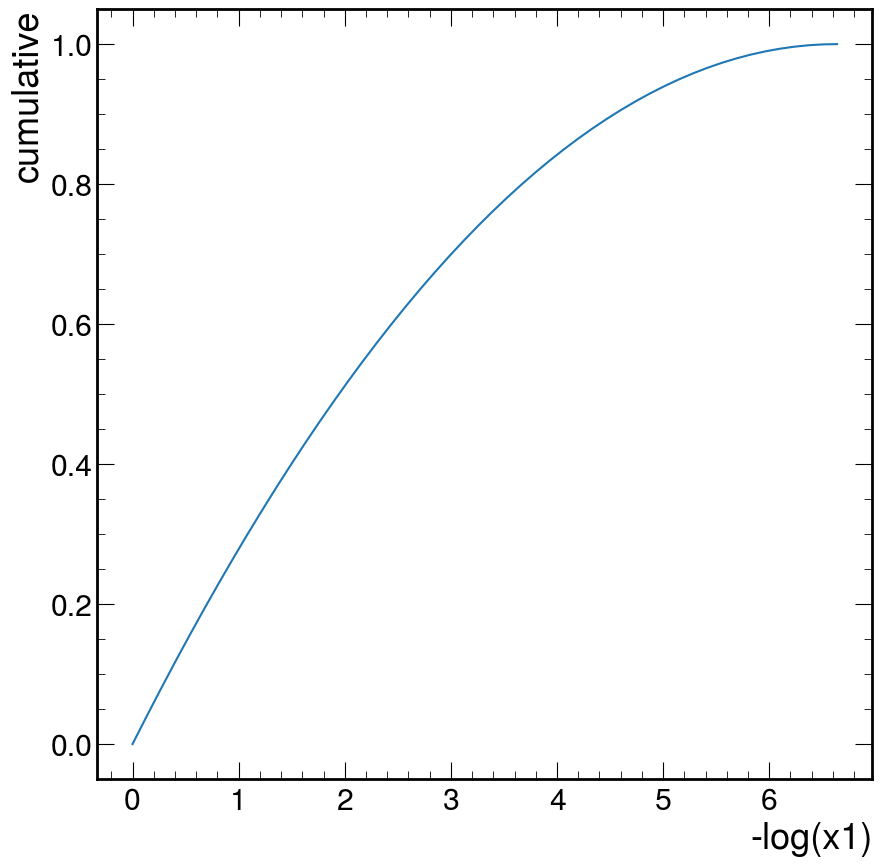

In [82]:
tau_min =  (tot_final_state_masses / 13000.)**2
logtau = np.log(tau_min)
m = -1
q = -logtau

x= np.linspace(0, q)



A = (m/2)*q**2 + q**2  # normalization of the curve
y = m*x  + q
ycum = cdf(x, m, q)

plt.plot(x, y)
plt.ylabel("-log(x1)")
plt.xlabel("-log(x1)")
plt.show() 
plt.plot(x, ycum)
plt.ylabel("cumulative")
plt.xlabel("-log(x1)")
plt.show()

Text(0, 1, '-log(x2)')

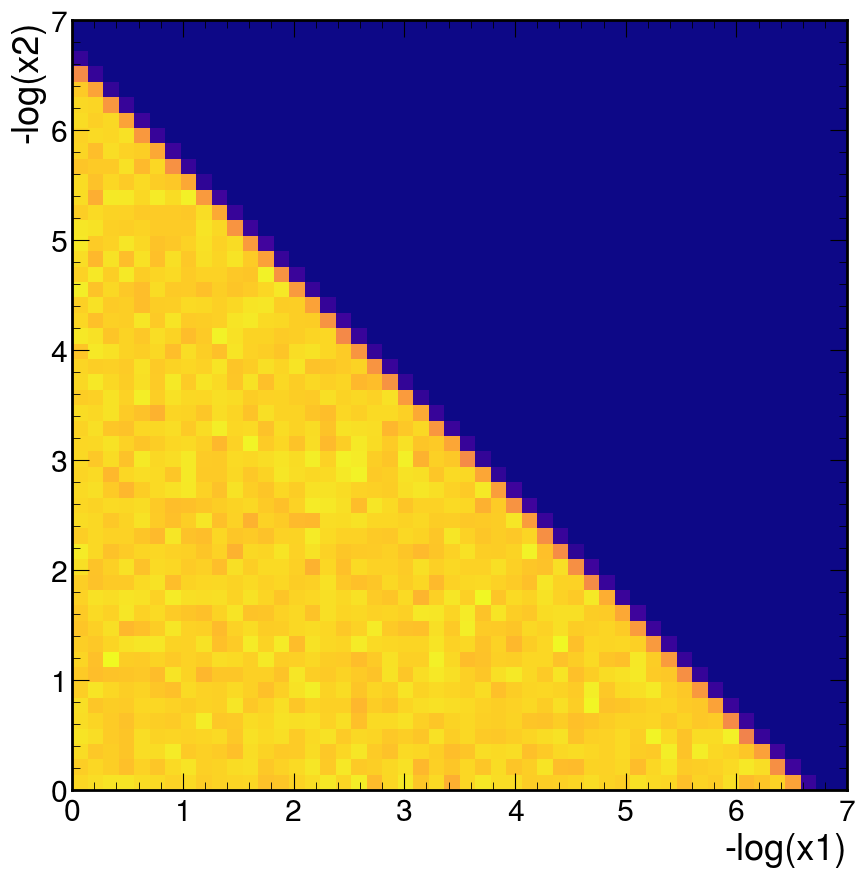

In [83]:
# Solve the inverse of the CDF to sample correctly -log(x1)
minus_logx1 = inverse_cdf(rnd[:,0], m, q)
# then sample -log(x2)
minus_logx2,_ = uniform_distr(  rnd[:,1], 0, m*minus_logx1 + q)

plt.hist2d(minus_logx1.numpy(), minus_logx2.numpy(), range=((0,7),(0,7)), bins=50,cmap="plasma");
plt.xlabel("-log(x1)")
plt.ylabel("-log(x2)")

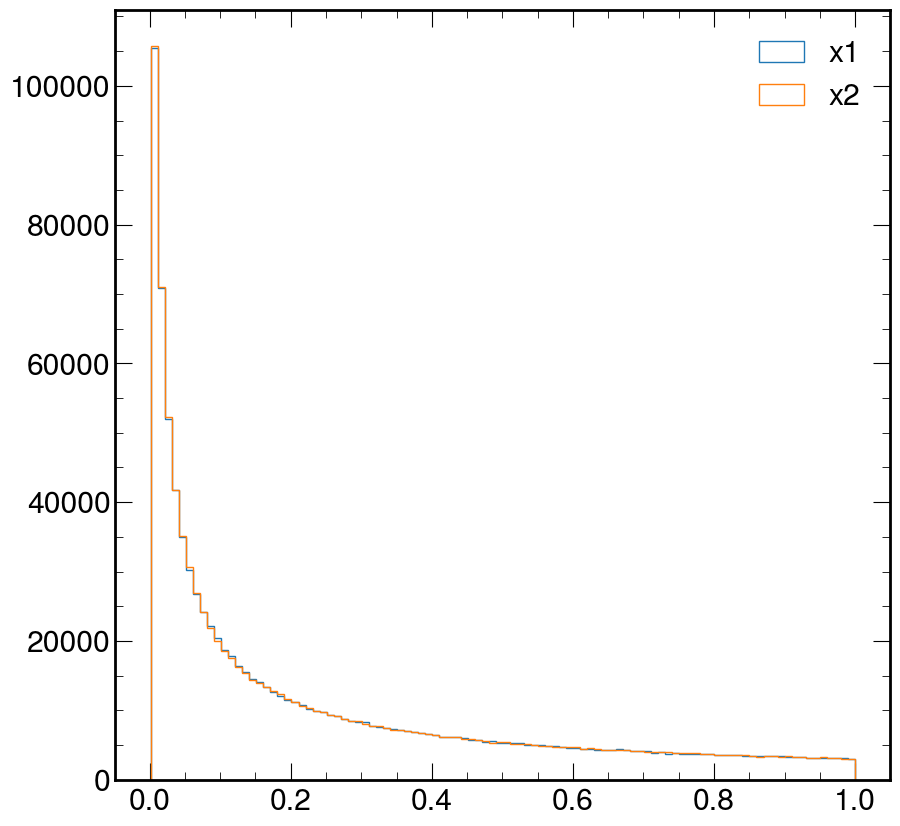

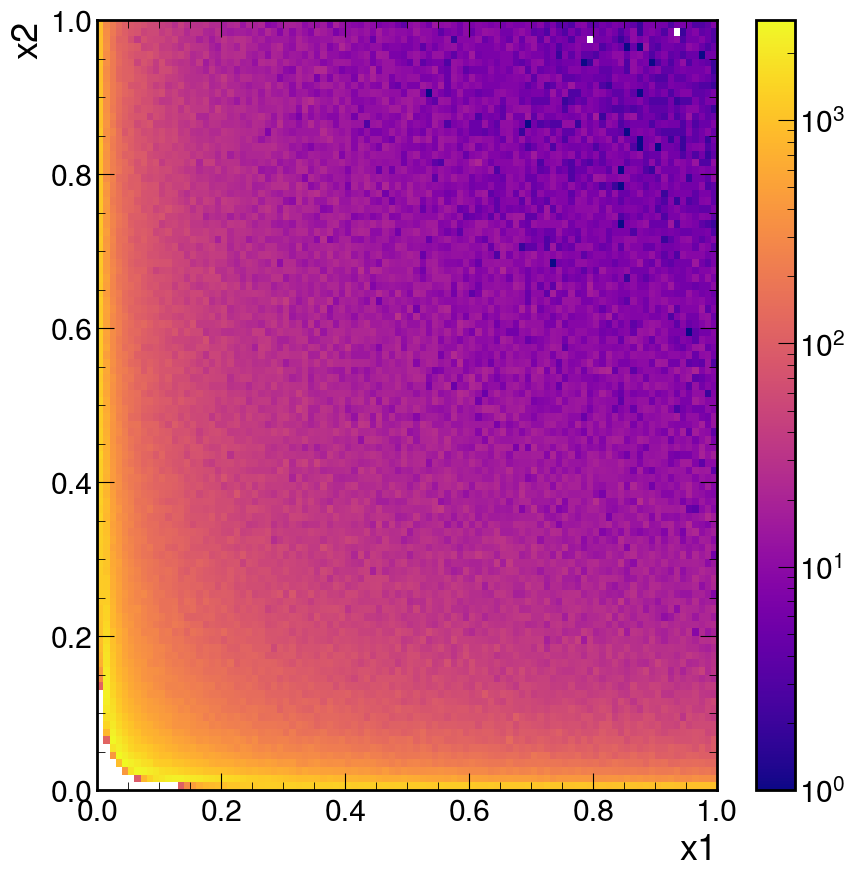

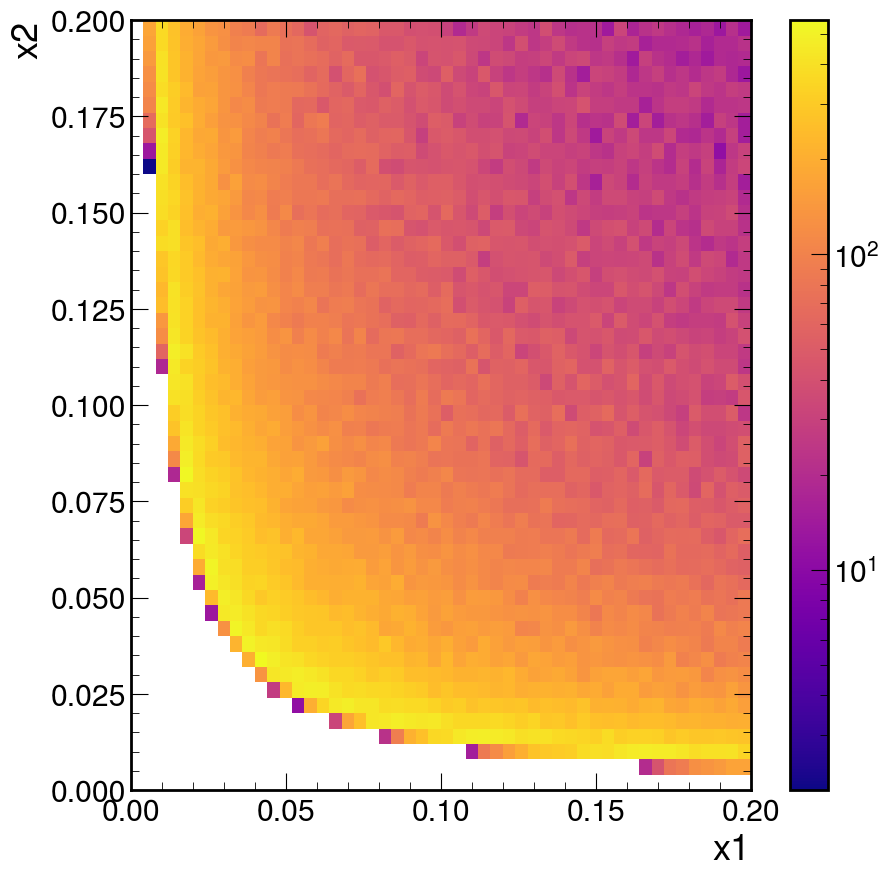

In [92]:
# exponentiate back
x1 = torch.exp(-minus_logx1)
x2 = torch.exp(-minus_logx2)

plt.hist(x1.numpy(), histtype="step", label="x1", bins=100);
plt.hist(x2.numpy(), histtype="step", label="x2", bins=100);
plt.legend()
plt.show()
plt.hist2d(x1.numpy(), x2.numpy(), range=((0,1),(0,1)), bins=100, cmap="plasma", norm=LogNorm());
plt.colorbar()
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

plt.hist2d(x1.numpy(), x2.numpy(), range=((0,0.2),(0,0.2)), bins=50, cmap="plasma", norm=LogNorm());
plt.colorbar()
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

In [87]:
minus_logx1.isnan().sum()

tensor(0)

In [88]:
x1.isnan().sum()

tensor(0)

# Inverse mapping

First of all $x_1$ and $x_2$ are converted to $-log$. Then $u_1$ is computed with the cdf of $x_1$.

$x_2$ instead is computed looking at the interval between 0 and $y = mx_1 + 1$

In [56]:
mlogx1 = -torch.log(x1)
mlogx2 = -torch.log(x2)

u_1 = cdf(mlogx1, m, q)
u_2 = mlogx2 / (m*mlogx1 + q)

Text(0, 1, 'u2')

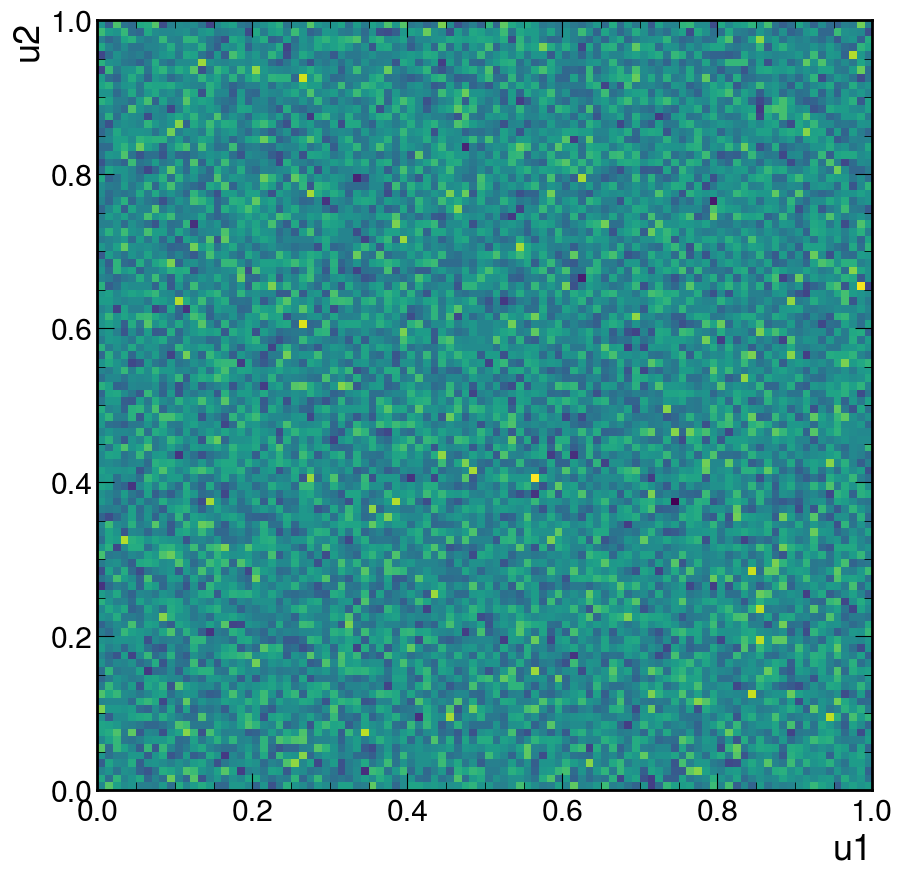

In [65]:
plt.hist2d(u_1.numpy(), u_2.numpy(), bins=(100,100), range=((0,1),(0,1)));
plt.xlabel("u1")
plt.ylabel("u2")